### $\color{indianred}{\text{ТРЕЋА ВЈЕЖБА ИЗ АСТРОСТАТИСТИКЕ, датум: 7.3.2025.}} $

### Централна гранична теорема

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

За произвољну расподјелу $h(x)$, са добро дефинисаном средњом вриједношћу ($\mu$) и 

стандардном девијацијом ($\sigma$), средња вриједност $N$ узорака $\{x_i\}$ из те расподјеле 

пратиће нормалну расподјелу $\mathcal{N}(\mu,\,\frac{\sigma}{\sqrt{N}})$. 

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy.stats
import scipy.interpolate
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from tqdm.notebook import tqdm
from astroML.stats.random import bivariate_normal
from astroML.stats import fit_bivariate_normal
from astroML.density_estimation import EmpiricalDistribution
import corner
from __future__ import print_function
from astropy.visualization import hist
from tqdm.notebook import tqdm

  0%|          | 0/100000 [00:00<?, ?it/s]

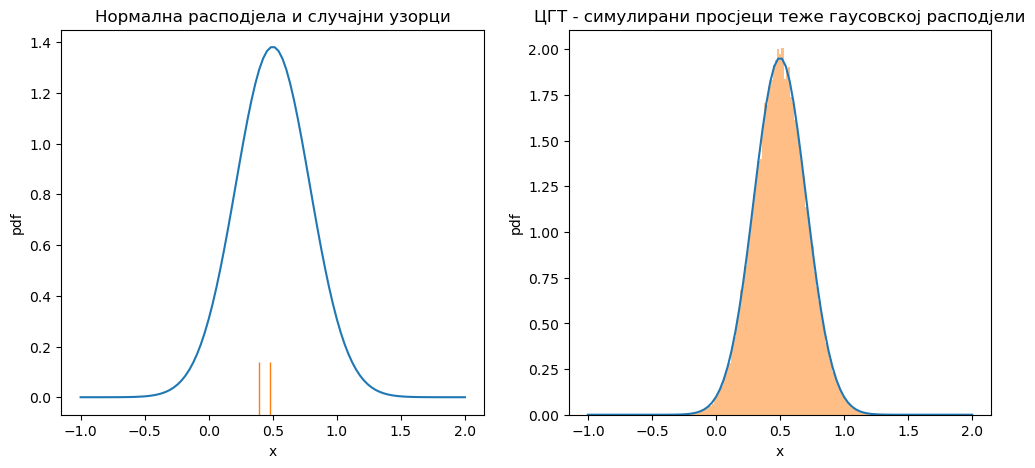

In [10]:
N = 2 # број извлачења
mu = 0.5 # локација
sigma_h = 1.0 / np.sqrt(12) # скала за h(x); погледати варијансу униформне расподјеле
sigma_cl = sigma_h / np.sqrt(N) # стандардна девијација према ЦГТ

xgrid = np.linspace(-1, 2, 100)  
distG_1 = scipy.stats.norm(mu, sigma_h) 
distG_2 = scipy.stats.norm(mu, sigma_cl)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(xgrid, distG_1.pdf(xgrid)) 
x = np.random.normal(mu, sigma_h, 2) # два случајна узорка из нормалне расподјеле
plt.plot(x, 0*x, '|', markersize=50) 
plt.title('Нормална расподјела и случајни узорци')
plt.xlabel('x')
plt.ylabel('pdf')


plt.subplot(122)
plt.plot(xgrid, distG_2.pdf(xgrid))
yy = []

for i in tqdm(np.arange(100000)): # број симулација
    xx = np.random.normal(mu, sigma_h, N) # N рандом извлачења
    yy.append(np.average(xx)) # додају се усредњене вриједности

plt.hist(yy, bins=100, histtype='stepfilled', alpha=0.5, density=True)
plt.xlabel('x')
plt.ylabel('pdf')
plt.title('ЦГТ - симулирани просјеци теже гаусовској расподјели') 
plt.show()

Можемо мало проширити примјер: централна гранична теорема примјењује се на аритметички просјек 

узорака из униформне расподјеле, али овај пут број узорака варира.

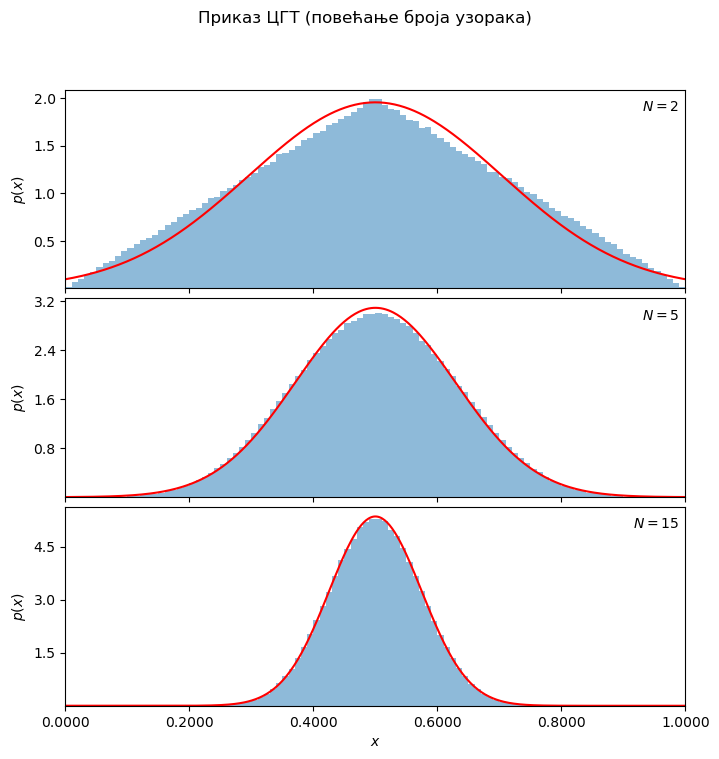

In [13]:
N = [2, 5, 15] # листа броја узорака за које се рачуна просјек
np.random.seed(42) # репродуцибилност
x = np.random.random((max(N), int(1e6))) # генерисање узорака


fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.05)

for i in range(len(N)):
    ax = fig.add_subplot(3, 1, i + 1)

    x_i = x[:N[i], :].mean(0) # израчунавање просјека

    ax.hist(x_i, bins=np.linspace(0, 1, 101), # хистограм просјека
            histtype='stepfilled', alpha=0.5, density=True)
 
    # теоријска нормална расподјела
    mu = 0.5 
    sigma = 1. / np.sqrt(12 * N[i])
    dist = norm(mu, sigma)
    x_pdf = np.linspace(-0.5, 1.5, 1000)
    ax.plot(x_pdf, dist.pdf(x_pdf), color='red')

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.001, None)

    # "фенси" подешавања
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    ax.text(0.99, 0.95, r"$N = %i$" % N[i],
            ha='right', va='top', transform=ax.transAxes)

    if i == len(N) - 1:
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
        ax.set_xlabel(r'$x$')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylabel('$p(x)$')

plt.suptitle('Приказ ЦГТ (повећање броја узорака)')
plt.show()

### Вишедимензионалне функције расподјеле

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Размотрамо дводимензионалну дистрибуцију $h(x,y)$, гдје важи:

$$
\int_{-\infty}^{\infty}dx\int_{-\infty}^{\infty}h(x,y)dy = 1.
$$

Имамо сљедеће дефиниције:

$$
\sigma_x^2 = \int_{-\infty}^{\infty}dx\int_{-\infty}^{\infty}(x-\mu_x)^2h(x,y)dxdy ,
$$

$$
\sigma_y^2 = \int_{-\infty}^{\infty}dy\int_{-\infty}^{\infty}(y-\mu_y)^2h(x,y)dxdy,
$$

$$
\mu_x=\int_{-\infty}^{\infty}dy\int_{-\infty}^{\infty}xh(x,y)dxdy
$$
$$
\sigma_{xy} = \text{cov}(x,y)\int_{-\infty}^{\infty}dy\int_{-\infty}^{\infty}(x-\mu_x)(y-\mu_y)h(x,y)dxdy
$$

Ако су $x$ и $y$ некорелисани, систем чине двије независне једнодимензионалне дистрибуције. 

Дводимензионална нормална функција расподјеле може се записати као:

$$
p(x,y;\,\mu_x,\mu_y,\sigma_x,\sigma_y)
= \frac{1}{2\pi\,\sigma_x\,\sigma_y\,\sqrt{1-\rho^2}}
e^{\frac{-z^2}{2(1-\rho^2)}},
$$

гдје имамо:

$$
z^2=\frac{(x-\mu_x)^2}{\sigma_x^2}
+ \frac{(y-\mu_y)^2}{\sigma_y^2}
- \frac{2\rho\,(x-\mu_x)\,(y-\mu_y)}{\sigma_x\,\sigma_y},
$$

гдје је

$$
\rho = \frac{\sigma_{xy}}{\sigma_x\,\sigma_y}
$$

бездимензиони коефицијент корелације. Ако $x$ и $y$ одлично корелишу имамо $\rho=\pm1$.

PDF више није хистограм, већ низ контура у равни. Оне су центриране око ($x=\mu_x,\,y=\mu_y$)

и "тилтоване" за угао $\alpha$ који је дат као:

$$
\tan{2\alpha}=2\rho\frac{\sigma_x\sigma_y}{\sigma_x^2-\sigma_y^2}=\frac{2\sigma_{xy}}{\sigma_x^2-\sigma_y^2}.
$$

Класична процјена (испрекидане линије) даје "biased" елипсе због аутлајера.


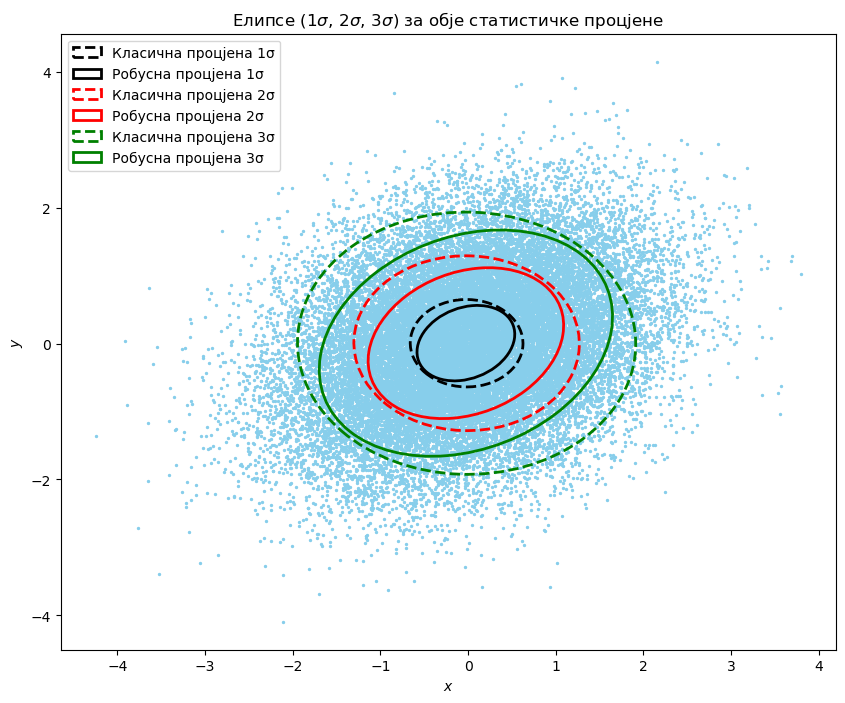

In [108]:
mux = 0 # центри биваријантне расподјеле
muy = 0

sigx = 1.0 # стандардне девијације
sigy = 1.0

sigxy = 0.3 # коваријанса

mean = np.array([mux, muy]) # вектор 
cov = np.array([[sigx**2, sigxy], [sigxy, sigy**2]]) # ков. матрица
x, y = np.random.multivariate_normal(mean, cov, 30000).T # генерисање тачака из бив. нормалне расподјеле

xout, yout = np.random.multivariate_normal(mean, # генерисање тзв. аутлајера (негдје кажемо неодређености)
                                           5 * cov * np.array([[1,-1],[-1,1]]), 
                                           6000).T

xt = np.append(x, xout) # комбинација 
yt = np.append(y, yout)

# процијењена средина (класична и прецизнија [робусна - тачнија у нашем примјеру])
mean_nr, sigma_x_nr, sigma_y_nr, alpha_nr = fit_bivariate_normal(xt, yt, robust=False)
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(xt, yt, robust=True)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

plt.scatter(x, y, s=2, facecolor='skyblue')

colors = ['black', 'red', 'green']  # боје за 1σ, 2σ, 3σ
for i, N in enumerate((1, 2, 3)):
    ax.add_patch(Ellipse(mean_nr, N * sigma_x_nr, N * sigma_y_nr, 
                         angle=alpha_nr * 180./np.pi, lw=2, 
                         ec=colors[i], fc='none', ls='dashed', 
                         label = f'Класична процјена {N}σ')) 
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=2, 
                         ec=colors[i], fc='none',
                         label = f'Робусна процјена {N}σ'))
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Елипсе ($1\sigma,\,2\sigma,\,3\sigma$) за обје статистичке процјене')
print('Класична процјена (испрекидане линије) даје "biased" елипсе због аутлајера.')
plt.legend()
plt.show()


Могућа је генерализација описа нормалне расподјеле у више димензија $M$,

коришћењем $M$-димензионог координатног вектора $\vec{x}$, "вектора средине" $\vec{\mu}$

и коваријансне матрице $C = E[(\vec{x}-\vec{\mu})(\vec{x}-\vec{\mu})^T]$, као:

$$
p(\vec{x}; \vec{\mu}, C) = \frac{1}{\sqrt{\det(2\pi C)}}e^{-\frac{1}{2} (\vec{x}-\vec{\mu})^T C^{-1} (\vec{x}-\vec{\mu})},
$$

где је:

$$
C_{kj} =\int_{-\infty}^{\infty}(x^k-\mu^k)(x^j-\mu^j)p(\vec{x}; \vec{\mu}, C)d^Mx,
$$

и такође важи:

$$
(\vec{x}-\vec{\mu})^T C^{-1} (\vec{x}-\vec{\mu})=\sum_{k,j}^M[C^{-1}]_{kj}(x^k-\mu^k)(x^j-\mu^j).
$$

---

У **двије димензије**, за нормалну расподјелу важи:

$$
\text{pdf(r)} = \frac{1}{2\pi s^2} e^{ - \frac{r^2}{2s^2}},
$$

$$
\text{cdf(x)} = 1 - e^{ -\frac{x^2}{2s^2}},
$$

са употребом поларних координата и имплицитним интегрисањем по углу.

Ово значи да се унутар $1\sigma$, код Гаусове расподјеле садржи приближно $39.3\%$,

а не $68\%$ као раније. Фактор $\pm1\sigma$ може да значи различите ствари у зависности

од тога о колико димензија је ријеч. Разлика је показана испод.

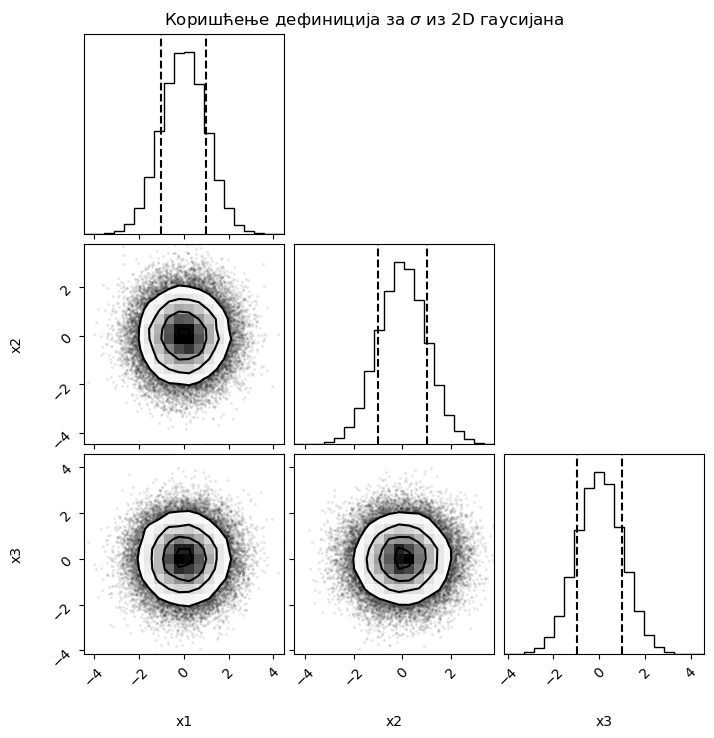

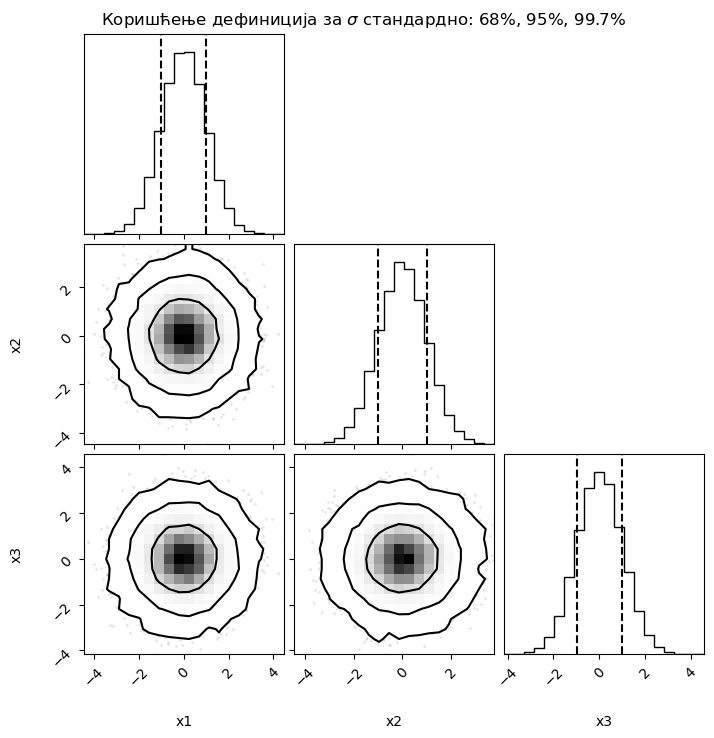

In [59]:
np.random.seed(42) # репродуцибилност
x = np.random.randn(50000, 3) # случајне тачке из стандардне нормалне расподјеле у три димензије

fig = corner.corner(x, quantiles=(0.16, 0.84), labels=['x1','x2','x3']);
fig.suptitle(r'Коришћење дефиниција за $\sigma$ из 2D гаусијана');

fig = corner.corner(x, quantiles=(0.16, 0.84), levels=(0.68,0.95,0.997), labels=['x1','x2','x3']);
fig.suptitle(r'Коришћење дефиниција за $\sigma$ стандардно: 68%, 95%, 99.7%');

### Коефицијенти корелације

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

**ПИРСОНОВ коефицијент**

Дата су два низа података дужине $N$, $\{x_i\}$ и $\{y_i\}$. Пирсонов коефицијент

корелације дефинисан је као:

$$
\rho_p = \frac{\sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^N (x_i - \bar{x})^2 \sum_{i=1}^N(y_i - \bar{y})^2}}
$$

Ако су парови $(x_i, y_i)$ из некорелисаних случајних промјенљивих, онда је $\rho = 0$.

За $\rho = \pm 1$ кажемо да су парови у потпуности корелисани или антикорелисани. 

Ако су $(x_i, y_i)$ узорци из некорелисаних, униваријатних, нормалних расподјела,

онда дистрибуција $\rho$ слиједи Студентову $t$ формулу са $k=N - 2$ степени слободе,

уз $t=\rho\sqrt{\frac{(N-2)}{(1-\rho^2)}}$, што омогућава одређивање $p$-вриједности за тест 

значајности. Иако је овај приступ формалнији, Пирсонов коефицијент није 

отпоран на одступања.

---

**СПИРМАНОВ коефицијент**

Ово је непараметарски метод. Узорци се замјењују њиховим ранговима. Статистика 

заснована на рангу отпорнија је на одступања. Свака вриједност у низу 

добија ранг од $1$ до $N$.

$$
\rho_s = \frac{\sum_{i=1}^{N} \bigl(R_i^x - \overline{R^x}\bigr)\,\bigl(R_i^y - \overline{R^y}\bigr)}
{\sqrt{\sum_{i=1}^{N} \bigl(R_i^x - \overline{R^x}\bigr)^2}\;\sqrt{\displaystyle \sum_{i=1}^{N} \bigl(R_i^y - \overline{R^y}\bigr)^2}}.
$$

---

**КЕНДАЛОВ коефицијент**


Кендалов коефицијент $\tau$ упоређује пар $(x_i, y_i)$ са паром $(x_j, y_j)$.

Пар је конкордантан ако важи $(x_i-x_j)(y_i-y_j)>0$, дискордантан је ако важи

супротно. Код потпуно позитивне корелације, сви парови су конкордантни, а код

потпуно негативне корелације, сви су дискордантни. Кендалов $\tau$ израчунава 

се преко:

$$
\tau = \frac{N_c - N_d}{N(N-1)/2},
$$

гдје су $N_c$ и $N_d$ број конкордантних, односно дискордантних парова.

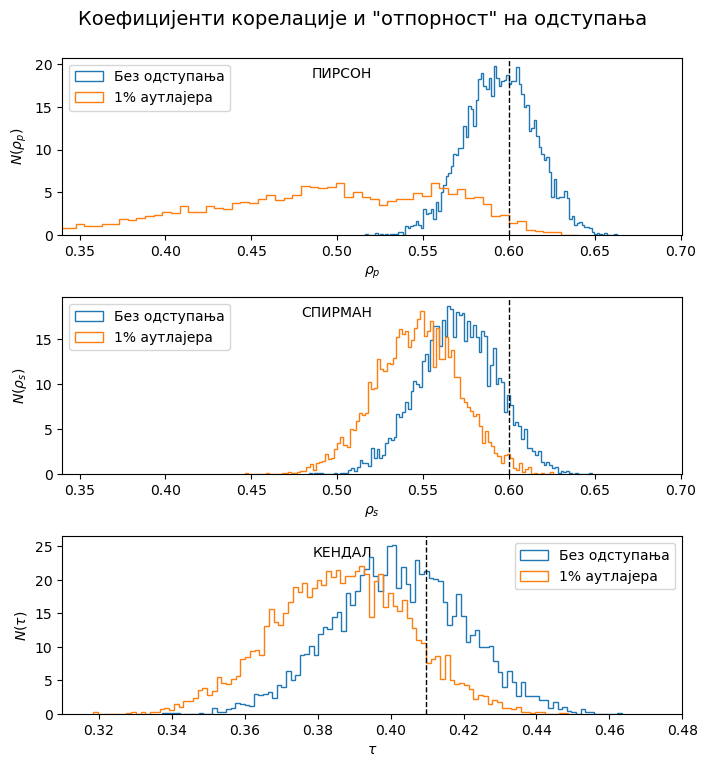

In [115]:
Nbootstraps = 5000 # bootstrap итерације
N = 1000 # тачке у основном узорку
sigma1 = 2.0 # параметри за биваријантну нормалну расподјелу
sigma2 = 1.0
mu = (10.0, 10.0)
alpha_deg = 45.0
alpha = alpha_deg * np.pi / 180
f = 0.01 # удио одступања

np.random.seed(0)
X = bivariate_normal(mu, sigma1, sigma2, alpha, N) # генерисање

X_out = X.copy()
X_out[:int(f * N)] = bivariate_normal(mu, 2, 5, # имитација убацивања аутлајера
                                      45 * np.pi / 180., int(f * N))

# "праве" вриједности корелација
rho_true = 0.6
tau_true = 2 / np.pi * np.arcsin(rho_true)

# Bootstrap је статистичка техника која омогућава процјену дисперзије и других
# карактеристика узорка, користећи репетитивно насумично узимање подузорака (са замјењивањем)
# из датог скупa података
def compute(N, Nbootstraps, X, X_out):
    results = np.zeros((3, 2, Nbootstraps))

    for k in range(Nbootstraps):
        #  насумични узорак
        ind = np.random.randint(N, size=N)
        
        # корелације за сет без и са аутлајерима
        for j, data in enumerate([X, X_out]):
            x = data[ind, 0]
            y = data[ind, 1]
            
            for i, statistic in enumerate([scipy.stats.pearsonr,
                                           scipy.stats.spearmanr,
                                           scipy.stats.kendalltau]):
                results[i, j, k] = statistic(x, y)[0]
                
    return results

results = compute(N, Nbootstraps, X, X_out)

# "фенси" подешавања
plt.figure(figsize=(8, 8))
plt.suptitle('Коефицијенти корелације и "отпорност" на одступања', fontsize=14)
plt.subplots_adjust(bottom=0.1, top=0.92, hspace=0.35)

histargs = (dict(label='Без одступања'),
            dict(label='%i%s аутлајера' % (int(f * 100), pct)))

distributions = ['ПИРСОН', 'СПИРМАН', 'КЕНДАЛ']
xlabels = [r'\rho_p', r'\rho_s', r'\tau']

for i in range(3):
    plt.subplot(3, 1, i+1)
    for j in range(2):
        plt.hist(results[i, j], 100, histtype='step',
                 density=True, **histargs[j])
    
    plt.legend(loc=2)
    
    ylim = plt.ylim()
    if i < 2:
        plt.plot([rho_true, rho_true], ylim, '--k', lw=1)
        plt.xlim(0.34, 0.701)
    else:
        plt.plot([tau_true, tau_true], ylim, '--k', lw=1)
        plt.xlim(0.31, 0.48)
    plt.ylim(ylim)
    
    plt.text(0.5, 0.95, distributions[i], color='black', ha='right', va='top',
             transform=plt.gca().transAxes)
    
    plt.xlabel('$%s$' % xlabels[i])
    plt.ylabel('$N(%s)$' % xlabels[i])

plt.legend()
plt.show()

### Коефицијенти корелације

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />


Нумеричке симулације мјерења (нпр. Монте Карло) често су неопходне за анализу

сложених утицаја селекционих ефеката и пристрасности. У том контексту, потребно

је узорковање из произвољне расподјеле $h(x)$. Постоје два уобичајена приступа.

1. **REJECTION SAMPLING** (одбацивање):

- одабере се *proposal* расподјела $q(x)$ која покрива репове $h(x)$;
   
- генерише се случајни узорак из $q(x)$;
   
- поређењем густина $\frac{h(x)}{C \cdot q(x)}$ (или уз помоћ максимума $h(x)$) 
   
     одлучује се да ли се предложени узорак прихвата или одбацује;
     
- поступак се понавља док се не прикупи довољно прихваћених узорака.


*Rejection sampling* је брз за имплементацију, али може бити мање ефикасан. 

Упркос томе, често је довољан за једноставне симулације. Испод ћемо

приказати један примјер. Узоркујемо из $p(x)\propto x+\sin{x}$, за $x\in(0,10)$.

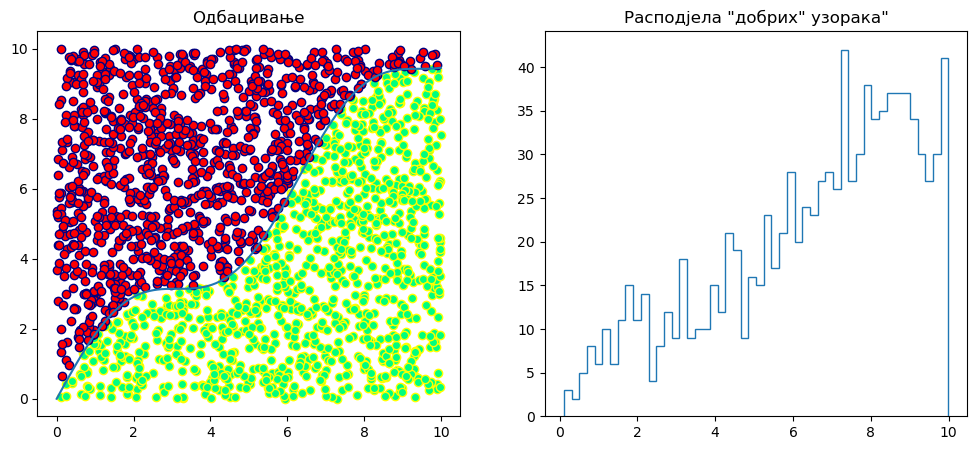

In [81]:
f = lambda x: x + np.sin(x) # тзв. анонимна функција, корисна овдје због лакоће употребе
N = 2000

xg = np.linspace(0, 10, 100)

ymax = 10
x = np.random.uniform(0, 10, N)
y = np.random.uniform(0, ymax, N)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(xg, f(xg))
plt.scatter(x[y<f(x)], y[y<f(x)], facecolor='springgreen',edgecolor='yellow') # прихваћени узорци
plt.scatter(x[y>f(x)], y[y>f(x)], facecolor='red', edgecolor='navy')
plt.title('Одбацивање')

goodpoints = x[y<f(x)]
plt.subplot(122)
plt.hist(goodpoints, bins=50, histtype='step')
plt.title('Расподјела "добрих" узорака"')

plt.show()

2. **INVERSE TRANSFORM SAMPLING** (инверзна трансформација):

- извлачимо случајну промјенљиву $u$ из униформне расподјеле на $[0, 1]$;

- примјењујемо инверзну функцију расподјеле $H^{-1}(u)$;

- резултат $x = H^{-1}(u)$ представља случајни узорак из оригиналне расподјеле.

Поступак узорковања из произвољне кумулативне расподјеле вјероватноће 
   
$H(x)$ ради без одбацивања тачака, што га чини врло ефикасним у односу на метод

*rejection sampling*. Једини изазов је наћи инверз $H(x)$, али он се може наћи

и кроз довољно добру нумеричку апроксимацију.

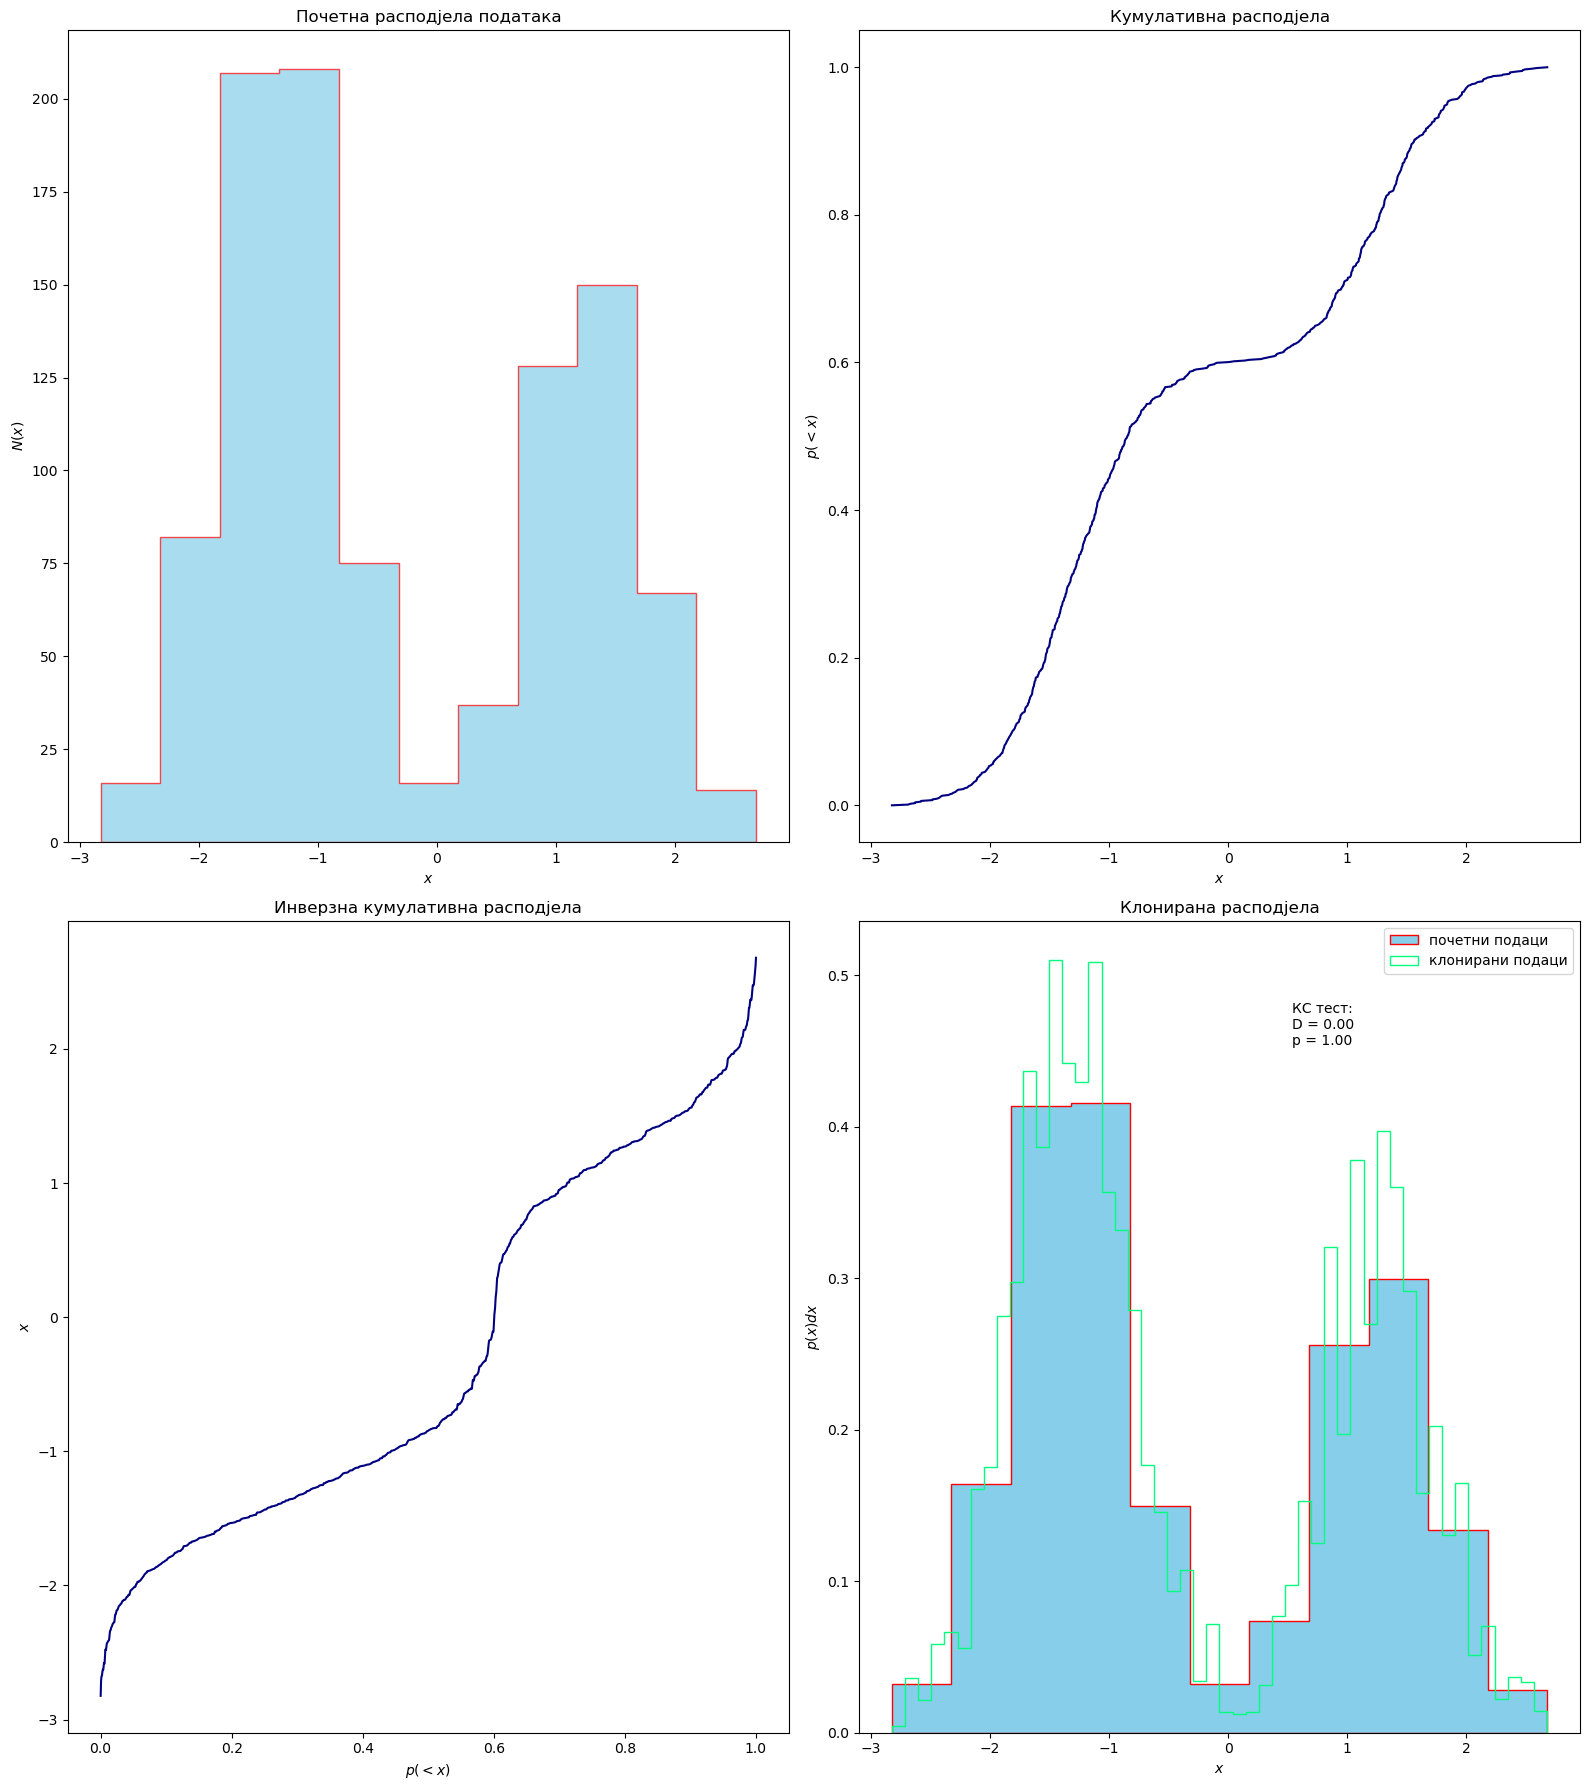

In [107]:
Ndata = 1000 # број тачака на почетку
Nclone = 100000 # број тачака које се генеришу приликом „клонирања“ почетне расподјеле 
np.random.seed(0)

dists = (scipy.stats.norm(-1.3, 0.5), scipy.stats.norm(1.3, 0.5)) # пар нормалних расподјела 
fracs = (0.6, 0.4) # дио података узет из прве, односно друге расподјеле

x = np.hstack([d.rvs(int(f * Ndata)) for d, f in zip(dists, fracs)]) # комбинација

x_cloned = EmpiricalDistribution(x).rvs(Nclone) # креирање емпиријске расподјеле засноване на x
D, p = scipy.stats.ks_2samp(x, x_cloned) # Колмогоров-Смирнов тест 

x.sort()
Px_cuml = np.linspace(0, 1, Ndata) # идеална кумулативна функција за сортиране податке

tck = scipy.interpolate.splrep(Px_cuml, x) # интерполација кумулативне расподјеле
Px_cuml_sample = np.linspace(0, 1, 10 * Ndata)
x_sample = scipy.interpolate.splev(Px_cuml_sample, tck) # омогућавање глатке инверзије к. расподјеле

plt.figure(figsize=(16, 18))

plt.subplot(221)
plt.hist(x, bins='auto', histtype='stepfilled', edgecolor='red', facecolor='skyblue', alpha=0.7)
plt.xlabel(r'$x$')
plt.ylabel(r'$N(x)$')
plt.title('Почетна расподјела података')

plt.subplot(222)
plt.plot(x, Px_cuml, color='navy')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(<x)$')
plt.title('Кумулативна расподјела')

plt.subplot(223)
plt.plot(Px_cuml_sample, x_sample, color='navy')
plt.ylabel(r'$x$')
plt.xlabel(r'$p(<x)$')
plt.title('Инверзна кумулативна расподјела')

plt.subplot(224)
plt.hist(x, bins='auto', density=True, histtype='stepfilled',
         edgecolor='red', facecolor='skyblue', label='почетни подаци')
plt.hist(x_cloned, bins='auto', density=True, histtype='step',
         color='springgreen', label='клонирани подаци')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)dx$')
plt.title('Клонирана расподјела')
plt.text(0.6, 0.9, f"КС тест:\nD = {D:.2f}\np = {p:.2f}",
         ha='left', va='top', transform=plt.gca().transAxes)

plt.legend()
plt.tight_layout()
plt.show()

**ЗАВРШНА НАПОМЕНА**: 

Изнад је споменут Колмогоров-Смирнов тест који заправо служи за провјеру

сличности између клонираних и оригиналних података ($D$ - максимална разлика

између кумулативних функција, $p$-вриједност). Читав приступ у посљедњем коду

омогућава дубљу анализу узорковања и верификацију ефикасности метода 

"клонирања" емпиријске расподјеле. У наставку је дат један користан $\href{http://www.matf.bg.ac.rs/p/files/1526271271-81-9_cas_statistika.html}{линк}$.